<a href="https://colab.research.google.com/github/ele9996/Heart-failure-clinical-records-analysis/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import random as rand


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import plotly.express as px
from scipy.special import expit
from sklearn import svm
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from numpy import mean

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
acc_original=[0,0,0,0]
acc_smote=[0,0,0,0]
f1_original=[0,0,0,0]
f1_smote=[0,0,0,0]
f1_original_cv=[0,0,0,0]
f1_smote_cv=[0,0,0,0]
acc_original_cv=[0,0,0,0]
acc_smote_cv=[0,0,0,0]

In [3]:
def nearest_neighbour(X, x):
    euclidean = np.ones(X.shape[0]-1)
    
    additive = [None]*(1*X.shape[1])
    additive = np.array(additive).reshape(1, X.shape[1])
    k = 0
    for j in range(0,X.shape[0]):
        if np.array_equal(X[j], x) == False:
            euclidean[k] = sqrt(sum((X[j]-x)**2))
            k = k + 1
    euclidean = np.sort(euclidean)
    weight = rand.random()
    while(weight == 0):
        weight = rand.random()
    additive = np.multiply(euclidean[:1],weight)
    return additive
    
def SMOTE_100(X):
    new = [None]*(X.shape[0]*X.shape[1])
    new = np.array(new).reshape(X.shape[0],X.shape[1])
    k = 0
    for i in range(0,X.shape[0]):
        additive = nearest_neighbour(X, X[i])
        for j in range(0,1):
            new[k] = X[i] + additive[j]
            k = k + 1
    return new 

#Heart failure data analysis



# 1 Introduction

The goal of the project is to try to predict if a patient with heart failure is likely to survive or not given certain medical records regarding clinical, body and lifestyle information.

Heart failure (HF) is a illness that occurs when the heart cannot pump enough blood to meet the needs of the body.

In order to try to make predictions about this topic I took into consideration a dataset containing the medical records of 299 heart failure patients collected both at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015.

The subject taken into consideration for my study are 105 women and 194 men whose age range in between 40 and 90.

The dataset analyzed contains the medical records of 299 heart failure patients consisting of 105 women and 194 men whoes ages range between 40 and 95 years old.

In this project several classifiers will be tested and compared in order to obtain the best results and several machine learning tecniques will be applied to the data in order to get the best out of them. 


The classifier taken into consideration for the analysis are:

- Logistic regression
- Linear Support Vector machine
- RBF Kernel Support Vector machine
- Random forest

They will be compared one between another to try to find the one that is able to better predict future entries.



#2 Data Exploration

##2.1 Dataset description 
The first step to start the analysis is studing the overall characteristics of the dataset.
A summary them is provided by the following table:


 ![Dataset Description](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/dataset_characteristics.JPG?raw=true)





From the table it is possible to notice the presence of 299 entries all defined by Integer or real numbers.
The description states also that there are no missing value in the collection.

The dataset is composed by 13 total features.
The first 12 represent the real features on which the analysis is based while the last one (DEATH_EVENT) represents the target variable.

In order to better understand the meaning of the features in their domain field and to quantifity them better another table containing this information is provided.


In particular the table contains a description of every feature in the dataset. 

Also other information like the unit of measurement and the range to which each feature belongs are given.


![feature Description](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/feature_description.JPG?raw=true)


##2.2 Dataset visualization


After understanding the features characterizing the dataset it's time to have a closer look at the entries.

The following table provides a sample visualization of the data:



In [4]:
#Dataset import and graphical visualization
df = pd.read_csv('https://raw.githubusercontent.com/ele9996/Heart-failure-clinical-records-analysis/master/heart_failure_clinical_records_dataset.csv')
df


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


After fouther analysis it is possible to notice the presence of both categorical features and numerical features.

The categorical features are: 


*   anaemia
*   diabetes
*   high_blood_pressure
*   sex
*   smoking
*   DEATH_EVENT(target variable)

All categorical features are binary (yes/no) features and are encoded in (0-1) notation

The numerical features are:


*   age
*   creatinine_phosphokinase
*   ejection_fraction
*   platelets
*   serum_creatinine
*   serum_sodium
*   time


Since the target variable is categorical, the problem is binary and so an analysis based on binary classification will be performed.

##2.3 Null entries check
According to what the dataset description says there shouldn't be null entries in the collections.

But since handling clean data is a priority in the analysis in order to not alterate results, a fourther check will be performed.


In [5]:
df.isnull().values.any()

False

As we can see from the output of the previous code the description statement was correct and there are no null entries in the dataset.
Since data seems to be consistent and right recorder no further data cleaning measurements are needed

##2.4 Correlation study
In order to know more informations about the attributes and to analyze them better it's important to study their mutual relationships.

One important relation worth considering is the **correlation** between attributes.

Correlation is a function of another quantity called the **covariance** whose formula is reported below:

$$cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N-1}$$

Covariance provides us information about trends in data which can be: 
- ascending trend ($cov_{x,y}>0$)
- descending trend ($cov_{x,y}<0$)
- no trend ($cov_{x,y}=0$)

Even if covariance seems to be a good measure to estimate relationship between data it is not: in fact covariance is highly dependent on the scale of the data 
and so it's interpretation may result very difficult.

However Correlation is extremely important in the calculation of the Pearson correlation between attributes.

Pearson correlation is a quantity that ranges between -1 and +1 and defines the degree to which a pair of variables are linearly related. 

It is a good measure in estimating data relationships because doesn't depend on the scale of the data.

The formula for calculating correlation is provided below: 


$${\displaystyle \rho _{X,Y}={\frac {\operatorname {cov} (X,Y)}{\sigma _{X}\sigma _{Y}}}}$$

A visual representation of correlation is provided by the following figure:

![correlation](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/correlation.JPG?raw=true)


To study Correlation between features in my data and in order to visualize them better a **Correlation Matrix** containing correlation coefficients is displayed below.

Since categorical variables are encoded in 0-1 notation it is possible to apply Pearson correlation also to them.

This kind of correlation is called "Point Biserial Correlation".

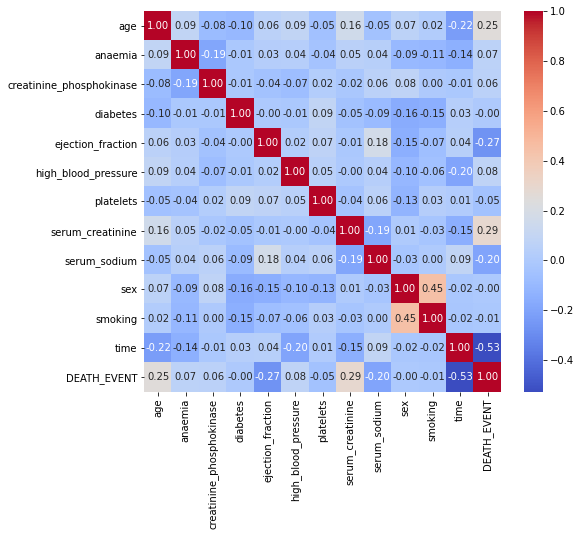

In [6]:
#I calculate correlation and print the correlation matrix
corr = df.corr()
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax,cmap='coolwarm')



In the heatmap it is possible to notice two main colors: Red and Blue.

The higher the correlation index becomes the closer the cell color tends to be red.

In the matrix it is possible to notice that there are no attributes that are significantly correlated.



##2.5 Features distribution visualization
Another characteristic of the dataset worth studying is the features distribution over the target variable "DEATH_EVENT".

In this chapter a distinction between numerical and categorical features is performed in terms of visualization.

In particular for **numerical** features, in order to detect the presence of outliers, a **boxplot** seems to be the most appropriate choice.

Concerning **categorical** features a **countplot/barplot** seems to be the most easily interpretable choice.

For both categorical and numerical features a plot of the distibution is given.


In [7]:


features = ['age','anaemia','creatinine_phosphokinase','diabetes','ejection_fraction','high_blood_pressure','platelets','serum_creatinine','serum_sodium','sex','smoking','time']
numerical_features=[features[0],features[2],features[4],features[6],features[7],features[8],features[11]]
categorical_features=[features[1],features[3],features[5],features[9],features[10]]

#Taking the features and placing in an array
x = df.loc[:, features].values
x_numerical=df.loc[:,numerical_features].values

x_categorical=df.loc[:,categorical_features].values

#Separating the target
y = df.loc[:,['DEATH_EVENT']].values#



x_Df = pd.DataFrame(data = x, columns = features)
x_numerical_Df = pd.DataFrame(data = x_numerical, columns = numerical_features)
x_categorical_Df = pd.DataFrame(data = x_categorical, columns = categorical_features)
y_df=pd.DataFrame(data = y, columns = ['DEATH_EVENT'])





###2.5.1 Numerical features
The following images contain the distribution of each numerical features with respect to the target variable "DEATH_EVENT"

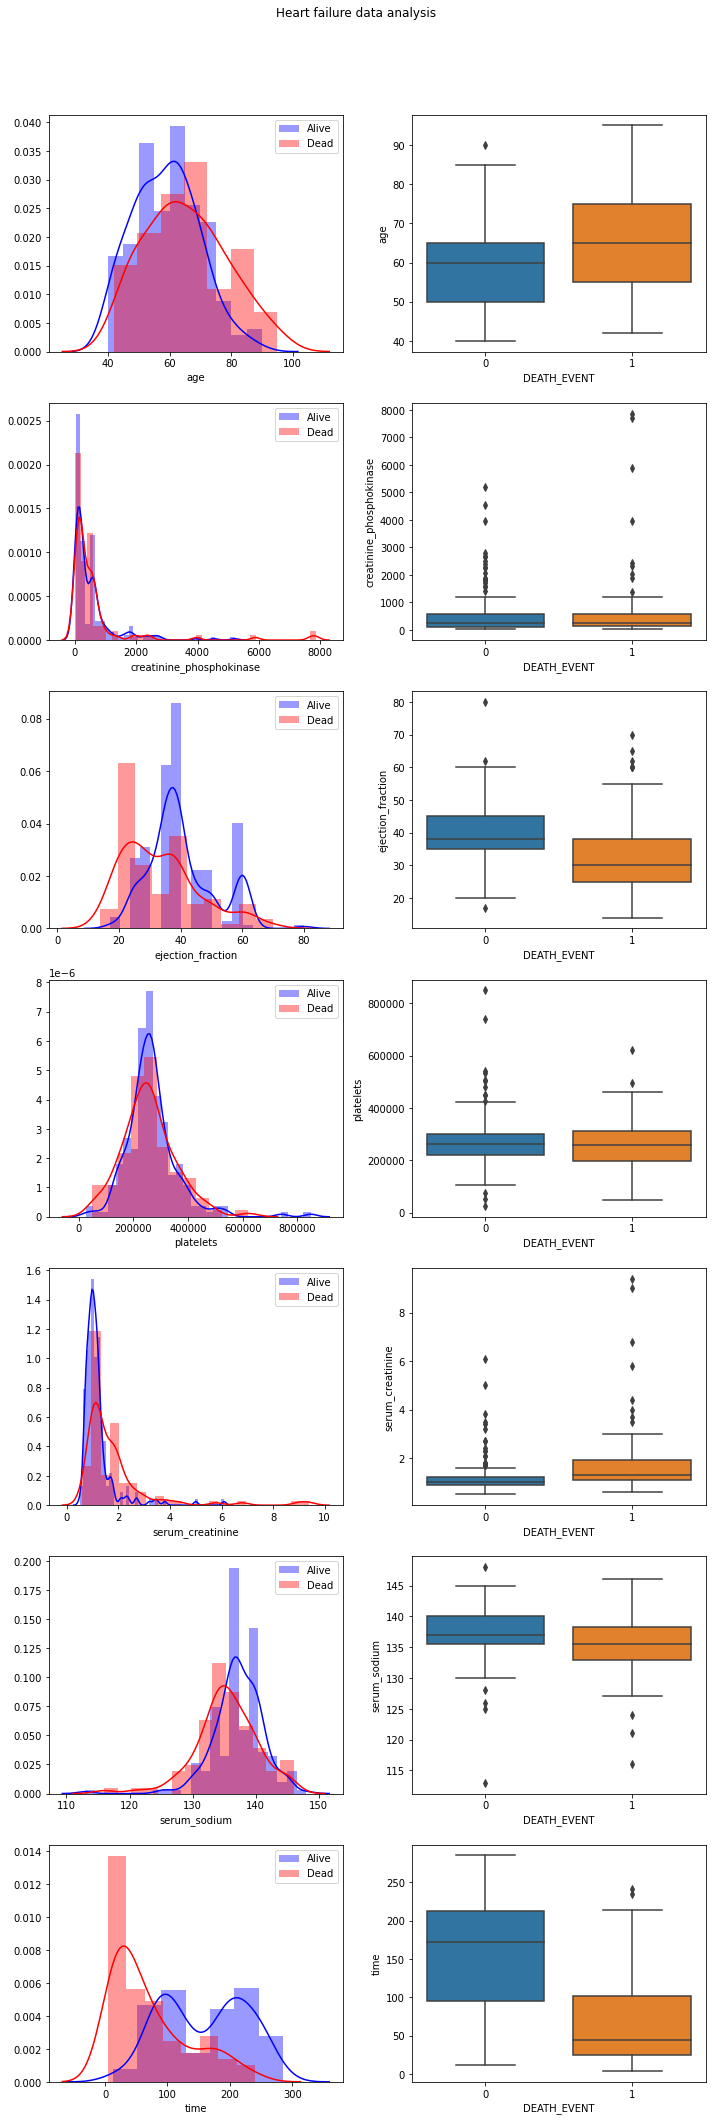

In [8]:
#Visualizing the selected features

fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_numerical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_numerical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.boxplot(x='DEATH_EVENT', y=x_numerical_Df[i], data=df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

From the figures it is possible to notice the presence of several outliers in particular in some body values related features.

Through a carefully study of the domain field I discovered that the outlier entries seems not to be impossible values for the considered features.

Therefore I concluded that it's very improbable for them to be data recoding errors (like for example a 1km for "height_measure" or 200 years old for "Age" measure).

For this reason I decided to keep them and going on with the analysis.



###2.5.2 Categorical features

In the following images the categorical features distribution over the target variable "DEATH_EVENT" is represented.

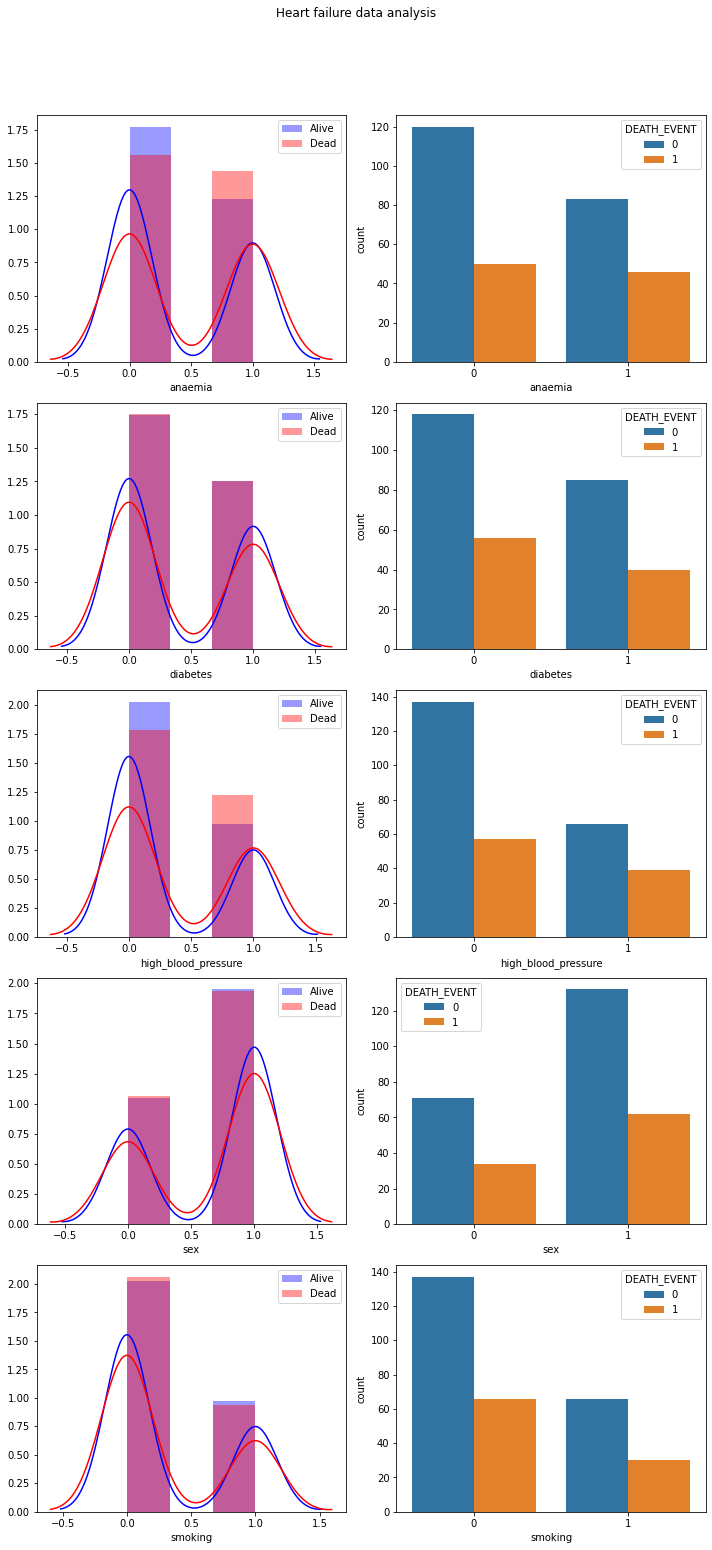

In [9]:
fig = plt.figure(figsize = (10, 50))
j = 0
for i in x_categorical_Df.columns:
    plt.subplot(12, 2, j+1)
    j += 1
    
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==0], color='b', label = 'Alive')
    sns.distplot(x_categorical_Df[i][df['DEATH_EVENT']==1], color='r', label = 'Dead')
    plt.legend(loc='best')
    plt.legend(loc='best')
    plt.subplot(12, 2, j+1)
    j += 1
    sns.countplot(x = x_categorical_Df[i], hue = 'DEATH_EVENT', data = df)

fig.suptitle('Heart failure data analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

##2.6 Check dataset unbalance

Since in the categorical features distribution plots a possible class unbalance was detected in this section a further investigation on this topic is carried on.

To try to discover if the dataset is potentially unbalanced I count the records having "DEATH_EVENT"==0 and the those having "DEATH_EVENT"==1.

The result is displayed in the following countplot:


From the plots above it is possible to notice that in each of them there are more "Alive" people than "Death".

This can be interpreted as an alarm signal for a possible class imbalance.

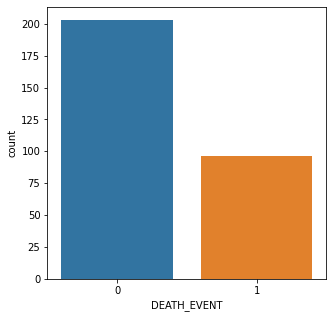

In [10]:
fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'DEATH_EVENT', data = df)

From the plot it is possible to notice that there are way more people labelled as "Alive" ("DEATH_EVENT"==0) than those labelled as "Dead" ("DEATH_EVENT"==1).

For this reason I decided to apply **SMOTE** oversampling tecnique on the part of the dataset designed as **training set** for the classifiers in order to try to rebalance it.


The name "SMOTE" stands for "Synthetic Minority Oversampling Technique" and is a way to add synthetic data to the minority represented class.

It's way of working can be summarized in the following steps:
- A random example from the minority class is first chosen. 
- k of the nearest neighbors for that example are found. 
- A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.



#3 Data Preparation


In [11]:

x_train_noPca, x_test_noPca, y_train_noPca, y_test_noPca = train_test_split(x, y, test_size = 0.2)

x_train_Df = pd.DataFrame(data = x_train_noPca, columns = features)
y_train_Df =pd.DataFrame(data=y_train_noPca, columns= ["DEATH_EVENT"])
x_test_Df = pd.DataFrame(data = x_test_noPca, columns = features)


trainDf = pd.concat([x_train_Df, y_train_Df], axis = 1)


In [12]:
#I divide the train set in training and validation set for performing standard validation
x_train_noPca, x_val_noPca, y_train_noPca, y_val_noPca = train_test_split(x_train_noPca,y_train_noPca,test_size= 0.2 )

x_trainsd_df=pd.DataFrame(data = x_train_noPca, columns = features)
x_valsd_df=pd.DataFrame(data = x_val_noPca, columns = features)
x_testsd_df=pd.DataFrame(data = x_test_noPca, columns = features)
y_trainsd_Df =pd.DataFrame(data=y_train_noPca, columns= ["DEATH_EVENT"])


x_trainsd_numerical=x_trainsd_df.loc[:,numerical_features]
x_testsd_numerical=x_testsd_df.loc[:,numerical_features]
x_valsd_numerical=x_valsd_df.loc[:,numerical_features]

x_trainsd_categorical=x_trainsd_df.loc[:,categorical_features]
x_testsd_categorical=x_testsd_df.loc[:,categorical_features]
x_valsd_categorical=x_valsd_df.loc[:,categorical_features]



##3.1 K-Fold 
In  k-fold  cross-validation,  the  original  dataset  is  ran-domly partitioned into k equal sized subsamples.  
Of the k subsamples, a single subsample is retained as the validationdata for testing the model, and the remaining k-1 sub-samples are used as training data. 

The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data.  

The k results can then be averaged to produce a single estimation. 

![kfold](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/grid.png?raw=true)

The advantage of this method over repeated random sub-sampling is that all observations are used for both training and validation, and each observation is used for validation exactly once.

Moreover it contributes to obtain less biased results.

In particular during this analysis **k=10** will be used as a value for k.

##3.2 Feature selection
Since the dataset has a consistent number of features to consider for the analysis an attempt of selecting the most relevant of them is performed.

Since the dataset presents both numerical and categorical features different tecniques for selection should be applied.

In particular for categorical features the **"Chi square test"** will be performed while for the numerical ones a selection based on the **"Mutual information"** will be made.






###3.2.1 Categorical features selection

For categorical features selection the **Chi square test** is performed.
Chi squared test is generally used to test the indipendence of two events.

In particular it measures how an expected count E and an observed count O deviates each other.

The formula regulating this deviation is reported below: 

$$\boldsymbol{\mathit{\chi_c ^{2} }} = \sum{\frac{(O_i - E_i)^{2}}{E_i}}$$

where $c$ are the degrees of freedom of the distribution, $O_i$ are the observed values and $E_i$ are the expected values.

From the formula it is possible to notice that When features are independendent from the response the chi value is low, while when they are dipendent from that the chi value is high.

Since in feature selection we want to select features that are highly dependent from the response, the higher the chi value the more the feature can be selected for model training.

In this case 3 features among all the categorical ones are selected.

In [13]:
def plot_selFeat(selectFeat, allFeat ):
  #1 --> true
  #0 --> false


  d = {} 
  
  # iterating through the elements of list 
  for i in allFeat: 
    d[i] = None
    
  
  for feat, val in d.items():
    d[feat]=0
    for f in selectFeat:
      if (feat==f):
        
        d[feat]=1
        break
        
    
    

  

  data_items = d.items()
  data_list = list(data_items)

  

  col= ["features","taken"]

  seldf = pd.DataFrame(data=data_list, columns=col)
  
  
  plot=sns.catplot(x="taken",y="features", kind="bar", data =seldf)

  return plot

  

The selected categorical features after chi square test are: ['diabetes', 'high_blood_pressure', 'smoking']


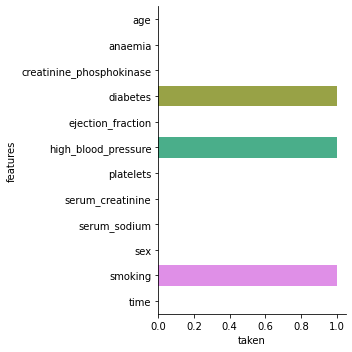

In [14]:

chi = SelectKBest(chi2, k=3)


chi.fit(x_trainsd_categorical, y_trainsd_Df)


# Get columns to keep
cols = chi.get_support(indices=True)

# Create new dataframe with only desired columns, or overwrite existing
x_trainsd_categorical_new = x_trainsd_categorical.iloc[:,cols]
x_valsd_categorical_new = x_valsd_categorical.iloc[:,cols]
x_testsd_categorical_new = x_testsd_categorical.iloc[:,cols]


sel_col=x_testsd_categorical_new.columns.tolist() 

#print selected columns
print("The selected categorical features after chi square test are: {}".format(sel_col))

figure=plot_selFeat(sel_col, features )


###3.2.2 Numerical features selection 
For selecting numerical features **Mutual Information** is exploited.

Mutual information is a measure between two random variables X and Y, that quantifies the amount of information obtained about one random variable, through the other one. 

It is defined by the following formula:

$$ I(X;Y) = \int_X\int_Y p(x,y) \log\frac{p(x,y)}{p(x)p(y)} dxdy$$

where $p(x,y)$ is the joint probability density function of $X$ and $Y$, and where $p(x)$ and $p(y)$ are the marginal density functions. 

The mutual information determines how similar the joint distribution $p(x,y)$ is to the products of the factored marginal distributions. 

For feature selection, we would like to maximize the mutual information between the selected features $X_S$ and the target variable $y$ as stated in the next formula:


$$ \tilde{S} = arg \max_S I(\textbf{X}\,_S;y), \quad \quad s.t.\left | S \right | = k,$$


where $k$ is the number of features we want to select

During this analysis a k=5 number of features are selected.



/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



The selected numerical features after mutual information test are: ['age', 'ejection_fraction', 'platelets', 'serum_creatinine', 'time']


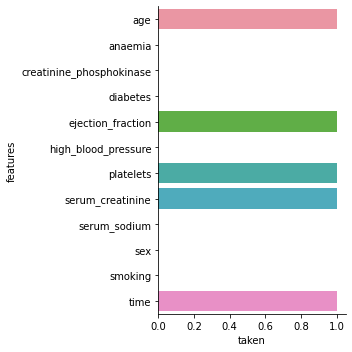

In [15]:
mi = SelectKBest(mutual_info_classif, k=5)
mi.fit(x_trainsd_numerical, y_trainsd_Df)


# Get columns to keep
cols = mi.get_support(indices=True)
# Create new dataframe with only desired columns, or overwrite existing
x_trainsd_numerical_new = x_trainsd_numerical.iloc[:,cols]
x_valsd_numerical_new = x_valsd_numerical.iloc[:,cols]
x_testsd_numerical_new = x_testsd_numerical.iloc[:,cols]

sel_col=x_testsd_numerical_new.columns.tolist()
print("The selected numerical features after mutual information test are: {}".format(sel_col)) 

figure=plot_selFeat(sel_col, features )


The total selected features for feeding classifier without K-fold cross validation are: ['age', 'ejection_fraction', 'platelets', 'serum_creatinine', 'time', 'diabetes', 'high_blood_pressure', 'smoking']


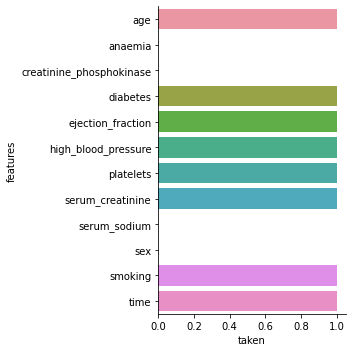

In [16]:
#creation of the new training,validation and test set 
x_trainstd_fs = pd.concat([x_trainsd_numerical_new, x_trainsd_categorical_new], axis = 1)
x_valstd_fs = pd.concat([x_valsd_numerical_new, x_valsd_categorical_new], axis = 1)
x_teststd_fs = pd.concat([x_testsd_numerical_new, x_testsd_categorical_new], axis = 1)

total_sel_col=x_teststd_fs.columns.tolist()
print("The total selected features for feeding classifier without K-fold cross validation are: {}".format(total_sel_col)) 

figure=plot_selFeat(total_sel_col, features )

###3.2.3 K-fold case
A particular case for feature selection occurs when k-fold cross validation is applied.
In fact applying feature selection before splitting the train and validation set may lead to overestimation of the accuracy problems.
For this reason the selection of the features is performed in the following way:

- A first round of k-fold cross validation is performed only for feature selection.
- During each fold, its preferred features are voted.
- The most preferred features will be given to the second cross validation round and to the classifier.

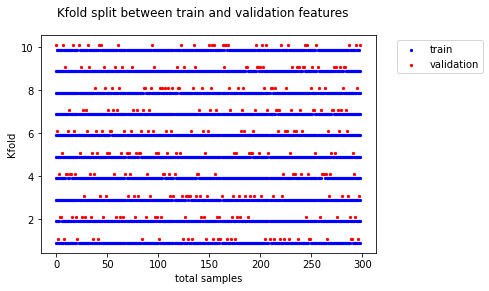

In [17]:
#Useful function for k-fold definition
def pr_N_mostFrequentfeat(arr, n, k): 
    sel_feat=[]
    um = {} 
    for i in range(n): 
        if arr[i] in um: 
            um[arr[i]] += 1
        else: 
            um[arr[i]] = 1
    a = [0] * (len(um)) 
    j = 0
    for i in um: 
        a[j] = [i, um[i]] 
        j += 1
    a = sorted(a, key = lambda x : x[0], 
                         reverse = True) 
    a = sorted(a, key = lambda x : x[1],  
                         reverse = True) 
                           
    # display the top k numbers  
    
    for i in range(k): 
        #print(a[i][0], end = " ")
        sel_feat.append(a[i][0])
    
    
    return sel_feat




rn = range(0,299)
kf10 = KFold(n_splits=10, shuffle=True)

def kfoldize2(kf, rn, shift=.1):
    train = pd.DataFrame()
    test = pd.DataFrame()
    i = 1
    for train_index, test_index in kf.split(rn):
        train_df = pd.DataFrame(np.take(rn, train_index), columns=["x"])
        train_df["val"] = i - shift
        train = train.append(train_df)

        test_df = pd.DataFrame(np.take(rn, test_index), columns=["x"])
        test_df["val"] = i + shift
        test = test.append(test_df)
        i += 1
    return train, test


train10, test10 = kfoldize2(kf10,rn)


plt.scatter(x="x",y="val",c="b",label="train",s=5,data=train10)
plt.scatter(x="x",y="val",c="r",label="validation",s=5,data=test10)
plt.ylabel("Kfold")
plt.xlabel("total samples")
plt.suptitle("Kfold split between train and validation features")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

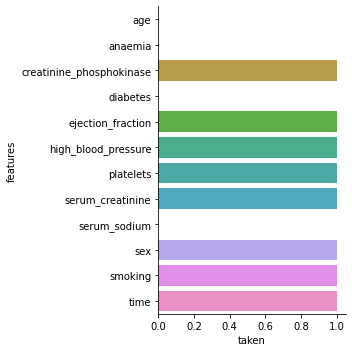

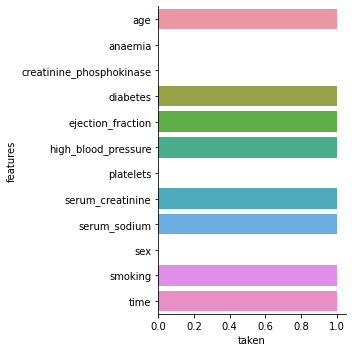

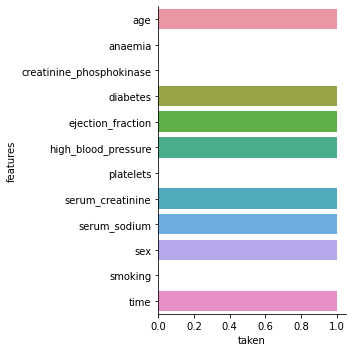

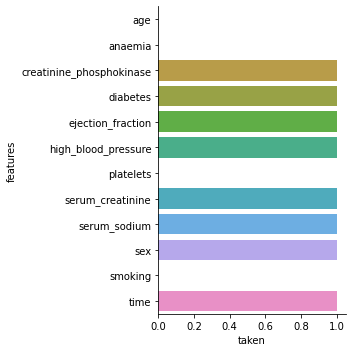

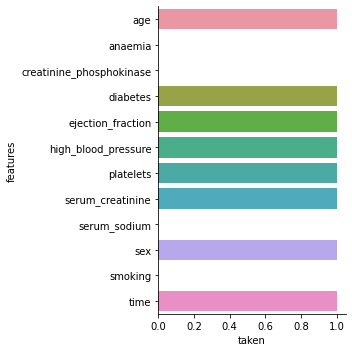

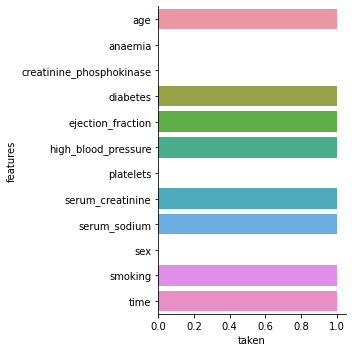

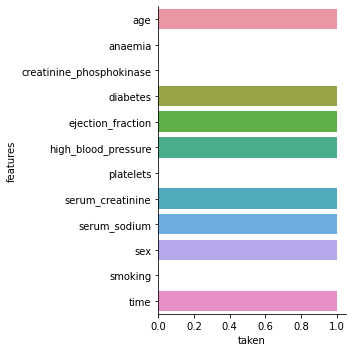

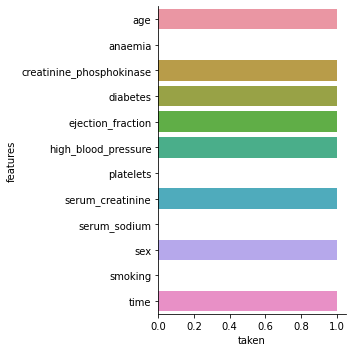

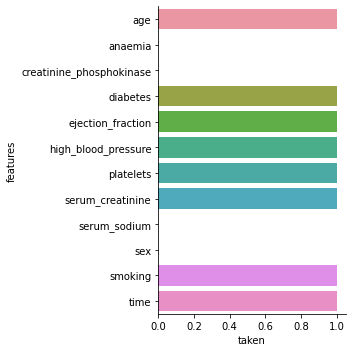

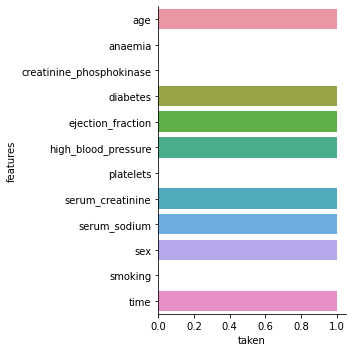

In [18]:
fold=0

voted_feat=[]

for train_index, test_index in kf10.split(trainDf):
      X_train = trainDf.iloc[train_index].loc[:, features]
      X_val = trainDf.iloc[test_index][features]
      y_train = trainDf.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = trainDf.loc[test_index]['DEATH_EVENT']
      
      #apply chi for categorical features and mi for numerical
      #Separate numerical and caregorical features
      x_trainCross_numerical =X_train.loc[:,numerical_features]
      x_trainCross_categorical = X_train.loc[:,categorical_features]

      #apply chi for categorical
      chi = SelectKBest(chi2, k=3)
      chi.fit( x_trainCross_categorical, y_train)
      cols = chi.get_support(indices=True)
      selected_catcolumns = x_trainCross_categorical.iloc[:,cols].columns.tolist()
      
      #apply mi for numerical
      mi = SelectKBest(mutual_info_classif, k=5)
      mi.fit( x_trainCross_numerical, y_train)
      cols = mi.get_support(indices=True)
      selected_numcolumns = x_trainCross_numerical.iloc[:,cols].columns.tolist()

      selected_columns= selected_numcolumns + selected_catcolumns

     
      
      
      plot_selFeat(selected_columns, features )
      
      


      voted_feat= voted_feat + selected_columns
      
      
      fold=fold+1


The final selected features for k-fold cross validation are :['time', 'serum_creatinine', 'high_blood_pressure', 'ejection_fraction', 'diabetes', 'age', 'sex', 'serum_sodium']


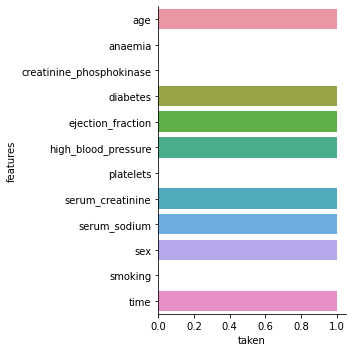

In [19]:
selected_feat=pr_N_mostFrequentfeat(voted_feat, len(voted_feat)-1, 8) 
print("The final selected features for k-fold cross validation are :{}".format(selected_feat))

figure=plot_selFeat(selected_feat, features )


In [20]:
#I create the training dataset with selected features to feed the classifier and I standardize it 
x_training_classifier_cross=x_train_Df.loc[:,selected_feat]
x_training_classifier_cross=StandardScaler().fit_transform(x_training_classifier_cross)
x_training_classifier_cross_df = pd.DataFrame(data = x_training_classifier_cross, columns = selected_feat)

cross_train_dataset=pd.concat([x_training_classifier_cross_df, y_train_Df], axis = 1)

#I create the test set with selected features to feed the classifier

x_test_classifier_cross=x_test_Df.loc[:,selected_feat]
x_test_classifier_cross=StandardScaler().fit_transform(x_test_classifier_cross)

##3.3 Data standardization

After a closer look to the data visualization table presented above it is possible to notice that features have different units of measurement.

Theory states that variables that are measured at different scales don't contribute equally to the analysis and might end up creating bias.

In order to avoid this issue a standardization of the data is performed.

Standardize data is calculated by first to determining the distribution mean and standard deviation for each feature and then by subtracting the mean for each of them.
Finally the values are divided by its standard deviation.

The following formula summarize all the process:

$${\displaystyle x'={\frac {x-{\bar {x}}}{\sigma }}}$$


Where ${\displaystyle x}$ is the original feature vector, ${\displaystyle {\bar {x}}={\text{average}}(x)}$ is the mean of that feature vector, and $\sigma $ is its standard deviation.

In [21]:
x_trainstd_fs=StandardScaler().fit_transform(x_trainstd_fs)
x_valstd_fs=StandardScaler().fit_transform(x_valstd_fs)
x_teststd_fs=StandardScaler().fit_transform(x_teststd_fs)


#4 Classifier

##4.1 Logistic Regression
Logistic regression a supervised classification algorithm that models the data using the sigmoid funtion (whose formula and representation are given below:




![sigmoid](https://tinyurl.com/y2hzzhww)

Logistic regression becomes a classification technique only when a decision threshold is brought into the picture. 

The setting of the threshold value is a very important aspect of Logistic regression and is dependent on the classification problem itself.

Based on the number of categories, Logistic regression can be classified as:

- **binomial**: target variable can have only 2 possible types: “0” or “1” 
- **multinomial**: target variable can have 3 or more possible types which are not ordered like “disease A” vs “disease B” vs “disease C”.
- **ordinal**: it deals with target variables with ordered categories(for example bad, good, excellent at which you can give the value 1,2,3)

In the case of our analysis, since our target variable is binary and only contains 0-1 values the "Binomial Logistic regression" will be taken into account.

Defining:

$$ p(X) = P(Y = 1|X) $$

 as the probability that $X$ belongs to class ”1”, Logistic regression uses equation:

$$ p(X) = \frac{e^{\beta_0 + \beta_1X}}{1+e^{\beta_0 + \beta_1X}} $$

to assign a label to one sample, using the logarithm to transform the equation above into a new expression:

$$ \log\frac{p(X)}{1-p(X)} = \beta_0 + \beta_1X $$

In order to estimate parameters $β0$ and $β1$, maximum likelihood estimation is exploited:
$$ l(\beta_0, \beta_1) = \prod_{i:y_i=1} p(x_i) \prod_{i:y_i=0}(1-p(x_i)) $$

which gives the probability of observed zeros and ones in data and parameters are chosen in order to maximize it.





###4.1.1 Original dataset

In this section the Linear SVM will be applied to the original dataset that has previusly been splitted into train, validation and training set with fixed items.

So neither k-fold cross validation nor smote oversampling tecnique has been applied.





In [22]:
def plot_Conf_Matrix(classifier,X_te,y_te):
 
  title= "Confusion matrix"
  class_names= ["Alive","Dead"]
  disp = plot_confusion_matrix(classifier, X_te, y_te,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize="true")
  disp.ax_.set_title(title)

  print(title)
  plt.show()

total accuracy of the model: 0.875
Accuracy on test set=0.7666666666666667
Precision on test set=0.8
Recall on test set=0.7314285714285714
F1 score on test set=0.7375
Confusion matrix


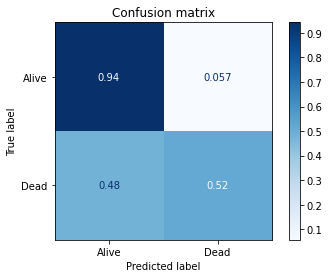

In [23]:
clf = LogisticRegression(random_state=0).fit(x_trainstd_fs,y_train_noPca.ravel())
y_p_LR=clf.predict(x_valstd_fs)
accuracy= accuracy_score(y_val_noPca,y_p_LR)
#get the mean of the accuracies for each fold
print("total accuracy of the model:",accuracy)      

y_onTest_LR=clf.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[2]=acc_on_Test
f1_original[2]=f1_on_Test


plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())


###4.1.2 Smote application only
In this section I tried to apply only the smote oversampling tecnique to the dataset with fixed training, validation and test set.
Smote oversampling tecnique has been applied to the training set only.



total accuracy of the model is: 0.8541666666666666
Accuracy on test set with smote=0.7333333333333333
Precision on test set= with smote0.7555555555555555
Recall on test set with smote=0.6971428571428571
F1 score on test set with smote=0.7
Confusion matrix


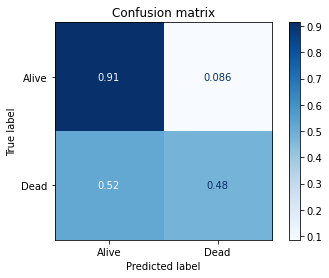

In [24]:

#apply smote
unique, counts = np.unique(y_train_noPca, return_counts=True)
minority_shape = dict(zip(unique, counts))[1]
x1 = np.ones((minority_shape,x_trainstd_fs.shape[1]))
k=0
for i in range(0,x_trainstd_fs.shape[0]):
    
    if y_train_noPca[i] == 1:
        
        x1[k] =x_trainstd_fs[i]
        k = k + 1
sampled_instances = SMOTE_100(x1)
X_f = np.concatenate((x_trainstd_fs,sampled_instances), axis = 0)
y_sampled_instances = np.ones(minority_shape)
y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)




clf = LogisticRegression(random_state=0).fit(X_f,y_f)
y_p_LR=clf.predict(x_valstd_fs)
acc= accuracy_score(y_val_noPca,y_p_LR)

#get the mean of the accuracies for each fold
print("total accuracy of the model is:",acc)      

y_onTest_LR=clf.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set= with smote{}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[2]=acc_on_Test
f1_smote[2]=f1_on_Test

plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

###4.1.3 k-fold cross validation application only
In this section I tried to apply the k-fold cross validation tecnique qithout the application of Smote

total accuracy of the model after Cross Validation is: 80.32608695652173
Accuracy on test set=0.7333333333333333
Precision on test set=0.8014842300556586
Recall on test set=0.6857142857142857
F1 score on test set=0.6825396825396826
Confusion matrix


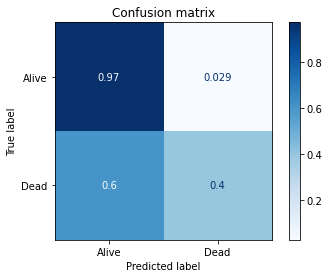

In [25]:

fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:,selected_feat]
      X_val = cross_train_dataset.iloc[test_index][selected_feat]
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT']


      clf = LogisticRegression(random_state=0).fit(X_train,y_train)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[2]=acc_on_Test
f1_original_cv[2]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

###4.1.4 both k-fold cross validation and Smote

In this section both k-fold cross validation and smote oversampling tecnique has been applied

total accuracy of the model after Cross Validation is: 79.90942028985508
Accuracy on test set with smote=0.7166666666666667
Precision on test set= with smote0.7406832298136645
Recall on test set with smote=0.6771428571428572
F1 score on test set with smote=0.6771130104463438
Confusion matrix


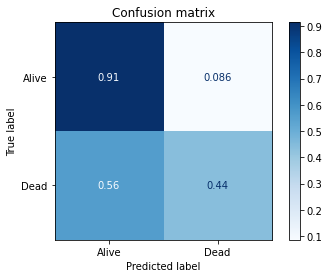

In [26]:
fold = 0
acc_array_LR=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:,selected_feat].values
      X_val = cross_train_dataset.iloc[test_index][selected_feat].values
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)




      clf = LogisticRegression(random_state=0).fit(X_f,y_f)
      y_p_LR=clf.predict(X_val)
      acc_array_LR[fold]= accuracy_score(y_val,y_p_LR)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_LR) * 100)      

y_onTest_LR=clf.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_LR)
precision_on_Test = precision_score(y_test_noPca, y_onTest_LR, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_LR, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_LR, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set= with smote{}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote_cv[2]=acc_on_Test
f1_smote_cv[2]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

##4.2 Linear Support Vector Machines

The goal of this classifier is to find a function $f(x)$ that performs a prediction of the target attribute $y$ with a maximum error equal to $\epsilon$
The problem of training can be formulated as a convex optimization problem in the following way:

$$min1/2||\theta||^2 $$
$$s.t\quad yi - \theta \cdot xi -b \le \epsilon  $$
$$\quad \quad \theta \cdot xi+b-yi \le \epsilon$$

where $yi$ is the value of the target attribute of the $i^{th}$ training object, xi is the value of the predictive attributes of the $i^{th}$ training object and $\theta$ and b are the parameters of the regression model.

But given a specific value of $\epsilon$ the problem is not always feasible.

For this reason the concept of **soft margin** was inserted and its aim is to reformulate the problem by considering the errors related to the predictions that do not satisfy the $\epsilon$ maximum distance.
So only the points outside the $\epsilon$-region contribute to the final cost.

Now the training problem can be formulated in this way:
$$1/2\min||\theta||^2 + C \sum_{x=1}^m (\xi_i +\xi_i^{*}) $$
$$s.t\quad yi - \theta \cdot xi -b \le \epsilon + \xi_i $$
$$\quad \quad \theta \cdot xi+b-yi \le \epsilon+  \xi_i^{*} $$
$$ \xi_i,\xi_i ^{*} \le 0,i=1,...,m $$

In this section I will validate the model on the validation set for different values of the hyperparameter C. 

In particular I will use this set of values:

$$C= [0.001,0.01,0.1,1,10,100,1000]$$

The model will be applied in four different situations:
- No application of Smote and k-fold cross validation
- Application of Smote but not of k-fold cross validation
- Performance of k-fold cross validation but no application of smote
- Application both of Smote and k-fold cross validation

After that the results will compared.

###4.2.1 Original dataset

In this section the Linear SVM will be applied to the original dataset that has previusly been splitted into train, validation and training set with fixed items.

So neither k-fold cross validation nor smote oversampling tecnique has been applied.





analyzing C=0.001
accuracy of the model: 0.7291666666666666
analyzing C=0.01
accuracy of the model: 0.7083333333333334
analyzing C=0.1
accuracy of the model: 0.8958333333333334
analyzing C=1
accuracy of the model: 0.9375
analyzing C=10
accuracy of the model: 0.9166666666666666
analyzing C=100
accuracy of the model: 0.9166666666666666
analyzing C=1000
accuracy of the model: 0.9166666666666666


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7666666666666667
Precision on test set=0.8
Recall on test set=0.7314285714285714
F1 score on test set=0.7375
Confusion matrix


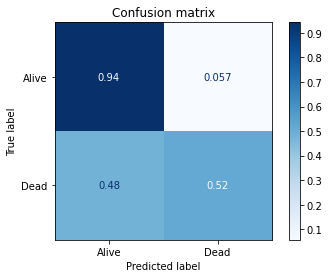

In [27]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  
  
  clf=svm.SVC(kernel='linear', C=C)
  clf.fit(x_trainstd_fs,y_train_noPca.ravel()) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_valstd_fs)
  accuracy= accuracy_score(y_val_noPca,y_p_SVM)
  
    
  #get the mean of the accuracies for each fold
  print("accuracy of the model:",accuracy)
  

  #searching for the best hyperparameter in the fold
  if (accuracy>acc_best):
    C_best=C
    acc_best=accuracy
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))

acc_original[0]=acc_on_Test
f1_original[0]=f1_on_Test


plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

From the result of the accuracies of the training and test set and from the confusion matrix it is possible to notice that the model performs in a very good way. 
But it can be biased due to the fact that datasets are fixed and that the dataset is imbalanced.

###4.2.2 Smote application only
In this section I tried to apply only the smote oversampling tecnique to the dataset with fixed training, validation and test set.
Smote oversampling tecnique has been applied to the training set only.



analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.8958333333333334
analyzing C=0.1
total accuracy of the model is: 0.8958333333333334
analyzing C=1
total accuracy of the model is: 0.875
analyzing C=10
total accuracy of the model is: 0.875
analyzing C=100
total accuracy of the model is: 0.875
analyzing C=1000
total accuracy of the model is: 0.875


Best hyperparameter for the model is C=0.01
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.7166666666666667
Precision on test set with smote=0.7604166666666667
Recall on test set with smote=0.6714285714285715
F1 score on test set with smote=0.6678606317160534
Confusion matrix


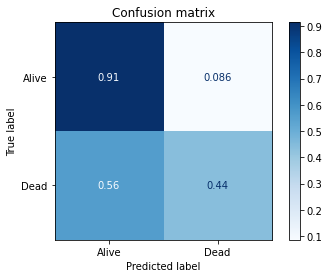

In [28]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  

  #apply smote
  unique, counts = np.unique(y_train_noPca, return_counts=True)
  minority_shape = dict(zip(unique, counts))[1]
  x1 = np.ones((minority_shape, x_trainstd_fs.shape[1]))
  k=0
  for i in range(0,x_trainstd_fs.shape[0]):
      
      if y_train_noPca[i] == 1:
          
          x1[k] = x_trainstd_fs[i]
          k = k + 1
  sampled_instances = SMOTE_100(x1)
  X_f = np.concatenate((x_trainstd_fs,sampled_instances), axis = 0)
  y_sampled_instances = np.ones(minority_shape)
  
  y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)
  #train the data on the training set
  clf=svm.SVC(kernel='linear', C=C)
  clf.fit(X_f,y_f) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_valstd_fs)
  acc= accuracy_score(y_val_noPca,y_p_SVM)
  
  
  print("total accuracy of the model is:",acc)
  

  #searching for the best hyperparameter in the fold
  if (acc>acc_best):
    C_best=C
    acc_best=acc
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[0]=acc_on_Test
f1_smote[0]=f1_on_Test


plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

From the comparison between the training and the test accuracy it is possible to notice that the model overfits a bit.
This may be due to the duplicated samples produced by Smote.

###4.2.3 k-fold cross validation application only
In this section I tried to apply the k-fold cross validation tecnique qithout the application of Smote

analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.27173913043478
analyzing C=0.01
total accuracy of the model after Cross Validation is: 74.47463768115942
analyzing C=0.1
total accuracy of the model after Cross Validation is: 79.52898550724638
analyzing C=1
total accuracy of the model after Cross Validation is: 83.27898550724638
analyzing C=10
total accuracy of the model after Cross Validation is: 83.22463768115942
analyzing C=100
total accuracy of the model after Cross Validation is: 81.57608695652175
analyzing C=1000
total accuracy of the model after Cross Validation is: 82.82608695652173


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7333333333333333
Precision on test set=0.8014842300556586
Recall on test set=0.6857142857142857
F1 score on test set=0.6825396825396826
Confusion matrix


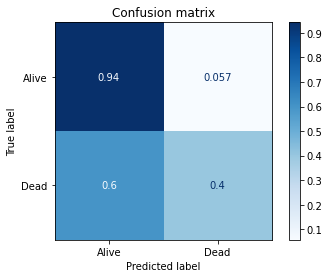

In [29]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat]
      X_val = cross_train_dataset.iloc[test_index][selected_feat]
      y_train =cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each C
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))

acc_original_cv[0]=acc_on_Test
f1_original_cv[0]=f1_on_Test


plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

From the confusion matrix it is possible to notice that the model performs very well. 
This may due to the fact that k-fold cross validation provides less biased results.

###4.2.4 both k-fold cross validation and Smote

In this section both k-fold cross validation and smote oversampling tecnique has been applied

analyzing C=0.001
total accuracy of the model after Cross Validation is: 69.83695652173914
analyzing C=0.01
total accuracy of the model after Cross Validation is: 80.32608695652173
analyzing C=0.1
total accuracy of the model after Cross Validation is: 79.92753623188406
analyzing C=1
total accuracy of the model after Cross Validation is: 80.34420289855072
analyzing C=10
total accuracy of the model after Cross Validation is: 80.77898550724638
analyzing C=100
total accuracy of the model after Cross Validation is: 80.30797101449275
analyzing C=1000
total accuracy of the model after Cross Validation is: 79.87318840579711


Best hyperparameter for the model is C=10
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.7333333333333333
Precision on test set with smote=0.7428180574555403
Recall on test set with smote=0.7028571428571428
F1 score on test set with smote=0.7069597069597069
Confusion matrix


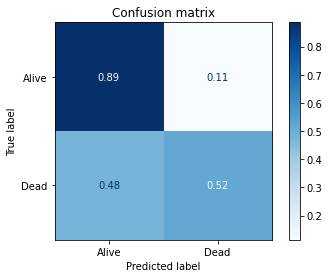

In [30]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat].values
      X_val = cross_train_dataset.iloc[test_index][selected_feat].values
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val =cross_train_dataset.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
      #train the data on the training set
      clf=svm.SVC(kernel='linear', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVM=bestModel.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVM)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVM, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVM, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVM, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[0]=acc_on_Test
f1_smote_cv[0]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())


##4.3 RBF Kernel Support Vector Machines

Sometimes data are organized so that it is not convenientto separate them by means of a linear function. 

In this cases the original feature are mapped into an higher order dimensional space by means of a kernel function $φ$ and the problem can be solved. 

The training problem then becomes:

$$1/2 min||θ||2+Cm∑x=1(ξi+ξi^{*})$$
$$s.t \quad yi−θ·φ(xi)−b≤\epsilon+ξi$$
$$θ·φ(xi) +b−yi≤\epsilon+ξi^{*}$$
$$ξi,ξi^{*}≤0,\quad i= 1,...,m$$

In particular the RBF kernel is a function defined as 
$$K(x,x′) =exp(−γ·||x−x'||^{2})$$

Where $\gamma= \frac{1}{2\sigma^{2}}$ and $||x−x′||$ is  the  squared  Euclidean Distance

###4.3.1 Original dataset

In this section the Linear SVM will be applied to the original dataset that has previusly been splitted into train, validation and training set with fixed items.

So neither k-fold cross validation nor smote oversampling tecnique has been applied.





analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.7291666666666666
analyzing C=0.1
total accuracy of the model is: 0.7291666666666666
analyzing C=1
total accuracy of the model is: 0.8541666666666666
analyzing C=10
total accuracy of the model is: 0.75
analyzing C=100
total accuracy of the model is: 0.75
analyzing C=1000
total accuracy of the model is: 0.75


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7333333333333333
Precision on test set=0.7741407528641571
Recall on test set=0.6914285714285714
F1 score on test set=0.6919127086007701
Confusion matrix


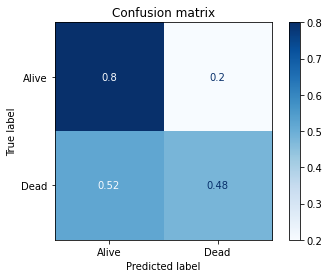

In [31]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  
  clf=svm.SVC(kernel='rbf', C=C)
  clf.fit(x_trainstd_fs,y_train_noPca.ravel()) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_valstd_fs)
  accuracy= accuracy_score(y_val_noPca,y_p_SVM)
  

  #get the mean of the accuracies for each fold
  print("total accuracy of the model is:",accuracy)
  

  #searching for the best hyperparameter in the fold
  if (accuracy>acc_best):
    C_best=C
    acc_best=accuracy
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_teststd_fs)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[1]=acc_on_Test
f1_original[1]=f1_on_Test

plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

###4.3.2 Smote application only
In this section I tried to apply only the smote oversampling tecnique to the dataset with fixed training, validation and test set.
Smote oversampling tecnique has been applied to the training set only.



analyzing C=0.001
total accuracy of the model is: 0.7291666666666666
analyzing C=0.01
total accuracy of the model is: 0.7291666666666666
analyzing C=0.1
total accuracy of the model is: 0.875
analyzing C=1
total accuracy of the model is: 0.8333333333333334
analyzing C=10
total accuracy of the model is: 0.8125
analyzing C=100
total accuracy of the model is: 0.75
analyzing C=1000
total accuracy of the model is: 0.75


Best hyperparameter for the model is C=0.1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.6666666666666666
Precision on test set with smote=0.6901669758812616
Recall on test set with smote=0.6171428571428571
F1 score on test set with smote=0.603174603174603
Confusion matrix


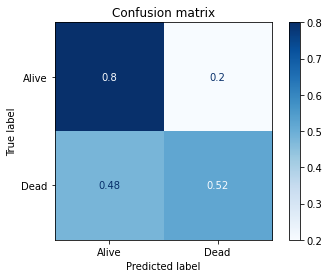

In [32]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  #apply smote
  unique, counts = np.unique(y_train_noPca, return_counts=True)
  minority_shape = dict(zip(unique, counts))[1]
  x1 = np.ones((minority_shape,x_trainstd_fs.shape[1]))
  k=0
  for i in range(0,x_trainstd_fs.shape[0]):
      
      if y_train_noPca[i] == 1:
        x1[k] =x_trainstd_fs[i]
        k = k + 1
  sampled_instances = SMOTE_100(x1)
  X_f = np.concatenate((x_trainstd_fs,sampled_instances), axis = 0)
  y_sampled_instances = np.ones(minority_shape)
  y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)



  #train the data on the training set
  clf=svm.SVC(kernel='rbf', C=C)
  clf.fit(X_f,y_f) #fit is used to train your pattern with some training data

  #evaluate the method on the validation set 

  y_p_SVM=clf.predict(x_valstd_fs)
  acc= accuracy_score(y_val_noPca,y_p_SVM)
  

  #get the mean of the accuracies for each fold
  print("total accuracy of the model is:",acc)
  

  #searching for the best hyperparameter in the fold
  if (acc>acc_best):
    C_best=C
    acc_best=acc
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_teststd_fs)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[1]=acc_on_Test
f1_smote[1]=f1_on_Test

plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

###4.3.3 k-fold cross validation application only
In this section I tried to apply the k-fold cross validation tecnique qithout the application of Smote

analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.23550724637681
analyzing C=0.01
total accuracy of the model after Cross Validation is: 70.38043478260869
analyzing C=0.1
total accuracy of the model after Cross Validation is: 70.28985507246377
analyzing C=1
total accuracy of the model after Cross Validation is: 80.32608695652176
analyzing C=10
total accuracy of the model after Cross Validation is: 76.15942028985508
analyzing C=100
total accuracy of the model after Cross Validation is: 74.92753623188406
analyzing C=1000
total accuracy of the model after Cross Validation is: 74.07608695652173


Best hyperparameter for the model is C=1
Testing the model on the test set with the best hyperparameter
Accuracy on test set=0.7333333333333333
Precision on test set=0.8014842300556586
Recall on test set=0.6857142857142857
F1 score on test set=0.6825396825396826
Confusion matrix


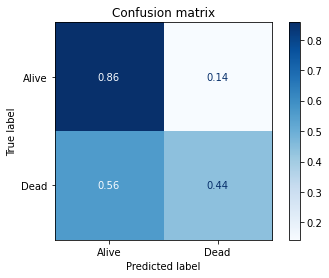

In [33]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat]
      X_val =cross_train_dataset.iloc[test_index][selected_feat]
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val =cross_train_dataset.loc[test_index]['DEATH_EVENT']

      #linear svm application 
      
      

      #print("Analyzing fold {} ...".format(fold))

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_train,y_train) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_classifier_cross)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[1]=acc_on_Test
f1_original_cv[1]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

After applying k-fold cross validation on the unbalanced dataset it is possible to notice that performances continue to be not so good especially for Dead event

###4.3.4 both k-fold cross validation and Smote

In this section both k-fold cross validation and smote oversampling tecnique has been applied

analyzing C=0.001
total accuracy of the model after Cross Validation is: 70.30797101449275
analyzing C=0.01
total accuracy of the model after Cross Validation is: 70.2355072463768
analyzing C=0.1
total accuracy of the model after Cross Validation is: 80.76086956521739
analyzing C=1
total accuracy of the model after Cross Validation is: 80.32608695652173
analyzing C=10
total accuracy of the model after Cross Validation is: 79.09420289855072
analyzing C=100
total accuracy of the model after Cross Validation is: 76.57608695652173
analyzing C=1000
total accuracy of the model after Cross Validation is: 73.65942028985508


Best hyperparameter for the model is C=0.1
Testing the model on the test set with the best hyperparameter
Accuracy on test set with smote=0.75
Precision on test set with smote=0.7579365079365079
Recall on test set with smote=0.7228571428571429
F1 score on test set with smote=0.7281787979462397
Confusion matrix


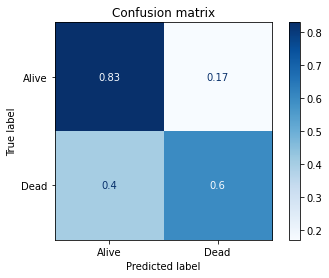

In [34]:
C_best=0
acc_best=0

for C in [0.001, 0.01, 0.1, 1, 10, 100,1000]:
  
  print("analyzing C={}".format(C))
  
  fold = 0
  acc_array_SVM=[0,0,0,0,0,0,0,0,0,0]
  for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat].values
      X_val =cross_train_dataset.iloc[test_index][selected_feat].values
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT'].values

      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)
    

    
      #train the data on the training set
      clf=svm.SVC(kernel='rbf', C=C)
      clf.fit(X_f,y_f) #fit is used to train your pattern with some training data
    
      #evaluate the method on the validation set 
   
      y_p_SVM=clf.predict(X_val)
      acc_array_SVM[fold]= accuracy_score(y_val,y_p_SVM)
      fold=fold+1
    
  #get the mean of the accuracies for each fold
  print("total accuracy of the model after Cross Validation is:",mean(acc_array_SVM) * 100)
  

  #searching for the best hyperparameter in the fold
  if (mean(acc_array_SVM)>acc_best):
    C_best=C
    acc_best=mean(acc_array_SVM)
    bestModel=clf


print("\n")
print("Best hyperparameter for the model is C={}".format(C_best)) 

#Testing the model on the test set with the best hyperparameters
print("Testing the model on the test set with the best hyperparameter")
y_onTest_SVMRBF=bestModel.predict(x_test_classifier_cross)
precision_on_Test = precision_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_SVMRBF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_SVMRBF, average='macro')

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_SVMRBF)
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[1]=acc_on_Test
f1_smote_cv[1]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

##4.4 Random Forest

A random forest is a model that fits a number of decision tree classifiers on various sub-samples of the dataset which are created by the use of bootstrapping.

![random forest](https://github.com/ele9996/Heart-failure-clinical-records-analysis/blob/master/report_images/randomForest.png?raw=true)

Every tree is trained on a subset of n samples randomly picked from the original dataset. 



Furthermore, a tree is learned on a random set of features. 

In this way the trees are decorrelated. 

The algorithm is characterized by many hyperparameters, including the number of trees and the maxdepth of every tree. 

In the inference stage it uses a majority vote over all trees to obtain the prediction.


Advantages and Disadvantages of Random Forest:
- It reduces overfitting in decision trees and helps to improve the  accuracy
- It is flexible to both classification and regression problems
- It works well with both categorical and continuous values
- It automates missing values present in the data
- Normalising of data is not required as it uses a rule-based approach.

However, despite these advantages, a random forest algorithm also has some drawbacks.
- It requires much computational power as well as resources as it builds numerous trees to combine their outputs. 
- It also requires much time for training as it combines a lot of decision trees to determine the class.
- Due to the ensemble of decision trees, it also suffers interpretability and fails to determine the significance of each variable.

In the application of the random forest the following steps are executed:
- Create a bootstrapped dataset (which means randomly select entries for the original dataset,given the assumption that we can select the same elemen more than once
- Create a decision tree using the bootstrapped dataset, but only using a random subset of variables (colums at each step).
- Repeat the previous two operations for several decision trees
- Then run the data to be predicted through each decision tree
- And see which of the options receives the more votes

###4.4.1 Original dataset

In this section the Linear SVM will be applied to the original dataset that has previusly been splitted into train, validation and training set with fixed items.

So neither k-fold cross validation nor smote oversampling tecnique has been applied.





total accuracy of the model is: 0.8958333333333334
Accuracy on test set=0.7666666666666667
Precision on test set=0.7838577291381669
Recall on test set=0.7371428571428571
F1 score on test set=0.7435897435897436
Confusion matrix


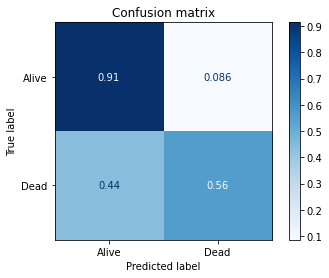

In [35]:
clf = RandomForestClassifier(max_depth=10, random_state=0).fit(x_trainstd_fs,y_train_noPca.ravel())
y_p_RF=clf.predict(x_valstd_fs)

acc= accuracy_score(y_val_noPca,y_p_RF)

#get the mean of the accuracies for each fold
print("total accuracy of the model is:",acc)      

y_onTest_RF=clf.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original[3]=acc_on_Test
f1_original[3]=f1_on_Test

plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())


###4.4.2 Smote application only
In this section I tried to apply only the smote oversampling tecnique to the dataset with fixed training, validation and test set.
Smote oversampling tecnique has been applied to the training set only.



total accuracy of the model is: 0.8958333333333334
Accuracy on test set with smote=0.8
Precision on test set with smote=0.8021978021978022
Recall on test set with smote=0.7828571428571429
F1 score on test set with smote=0.7884841363102233
Confusion matrix


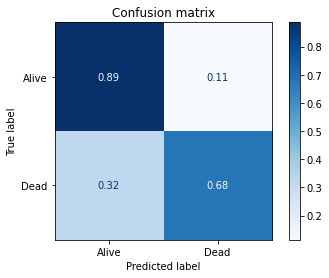

In [36]:
#apply smote
unique, counts = np.unique(y_train_noPca, return_counts=True)
minority_shape = dict(zip(unique, counts))[1]
x1 = np.ones((minority_shape, x_trainstd_fs.shape[1]))
k=0
for i in range(0,x_trainstd_fs.shape[0]):
    
    if y_train_noPca[i] == 1:
        
        x1[k] = x_trainstd_fs[i]
        k = k + 1
sampled_instances = SMOTE_100(x1)
X_f = np.concatenate((x_trainstd_fs,sampled_instances), axis = 0)
y_sampled_instances = np.ones(minority_shape)
y_f = np.concatenate((y_train_noPca.ravel(),y_sampled_instances), axis=0)


clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_f,y_f)
y_p_RF=clf.predict(x_valstd_fs)


acc= accuracy_score(y_val_noPca,y_p_RF)

#get the mean of the accuracies for each fold
print("total accuracy of the model is:",acc)      

y_onTest_RF=clf.predict(x_teststd_fs)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))
acc_smote[3]=acc_on_Test
f1_smote[3]=f1_on_Test

plot_Conf_Matrix(clf,x_teststd_fs,y_test_noPca.ravel())

###4.4.3 k-fold cross validation application only
In this section I tried to apply the k-fold cross validation tecnique qithout the application of Smote

total accuracy of the model after Cross Validation is: 84.94565217391303
Accuracy on test set=0.8
Precision on test set=0.8112965340179717
Recall on test set=0.7771428571428571
F1 score on test set=0.7846889952153109
Confusion matrix


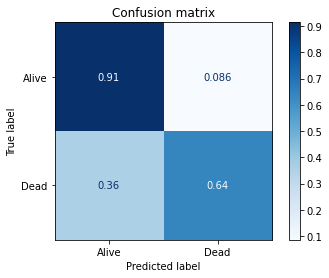

In [37]:

fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat]
      X_val = cross_train_dataset.iloc[test_index][selected_feat]
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT']
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT']


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train,y_train)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set={}".format(acc_on_Test))
print("Precision on test set={}".format(precision_on_Test))
print("Recall on test set={}".format(recall_on_Test)) 
print("F1 score on test set={}".format(f1_on_Test))
acc_original_cv[3]=acc_on_Test
f1_original_cv[3]=f1_on_Test


plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

###4.4.4 both k-fold cross validation and Smote

In this section both k-fold cross validation and smote oversampling tecnique has been applied

total accuracy of the model after Cross Validation is: 83.22463768115942
Accuracy on test set with smote=0.7833333333333333
Precision on test set with smote=0.7901785714285714
Recall on test set with smote=0.7971428571428572
F1 score on test set with smote=0.7827903091060986
Confusion matrix


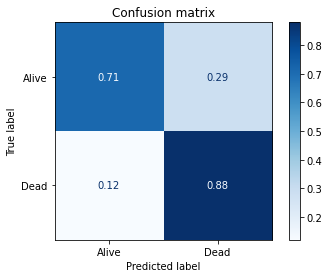

In [38]:
fold = 0
acc_array_RF=[0,0,0,0,0,0,0,0,0,0]
for train_index, test_index in kf10.split(cross_train_dataset):
      X_train = cross_train_dataset.iloc[train_index].loc[:, selected_feat].values
      X_val = cross_train_dataset.iloc[test_index][selected_feat].values
      y_train = cross_train_dataset.iloc[train_index].loc[:,'DEATH_EVENT'].values
      y_val = cross_train_dataset.loc[test_index]['DEATH_EVENT'].values


      #apply smote
      unique, counts = np.unique(y_train, return_counts=True)
      minority_shape = dict(zip(unique, counts))[1]
      x1 = np.ones((minority_shape, X_train.shape[1]))
      k=0
      for i in range(0,X_train.shape[0]):
          
          if y_train[i] == 1:
              
              x1[k] = X_train[i]
              k = k + 1
      sampled_instances = SMOTE_100(x1)
      X_f = np.concatenate((X_train,sampled_instances), axis = 0)
      y_sampled_instances = np.ones(minority_shape)
      y_f = np.concatenate((y_train,y_sampled_instances), axis=0)


      clf = RandomForestClassifier(max_depth=10, random_state=0).fit(X_f,y_f)
      y_p_RF=clf.predict(X_val)

      
      acc_array_RF[fold]= accuracy_score(y_val,y_p_RF)
      fold=fold+1
#get the mean of the accuracies for each fold
print("total accuracy of the model after Cross Validation is:",mean(acc_array_RF) * 100)      

y_onTest_RF=clf.predict(x_test_classifier_cross)

acc_on_Test= accuracy_score(y_test_noPca,y_onTest_RF)
precision_on_Test = precision_score(y_test_noPca, y_onTest_RF, average='macro')
recall_on_Test=recall_score(y_test_noPca, y_onTest_RF, average='macro')
f1_on_Test=f1_score(y_test_noPca, y_onTest_RF, average='macro')
print("Accuracy on test set with smote={}".format(acc_on_Test))
print("Precision on test set with smote={}".format(precision_on_Test))
print("Recall on test set with smote={}".format(recall_on_Test)) 
print("F1 score on test set with smote={}".format(f1_on_Test))

acc_smote_cv[3]=acc_on_Test
f1_smote_cv[3]=f1_on_Test

plot_Conf_Matrix(clf,x_test_classifier_cross,y_test_noPca.ravel())

#Conclusion
In the following table a summary of the main principal results is reported.

In [39]:
result_Table =pd.DataFrame({'model': ['Linear SVM', 'RBF Kernel SVM','Logistic Regression','Random Forest'], 'Holdout Original Accuracy': acc_original, 'Holdout Original F1': f1_original, 'Holdout SMOTE Accuracy': acc_smote, 'Holdout SMOTE F1': f1_smote, 'Holdout Original CV Accuracy':acc_original_cv, 'Holdout Original CV F1': f1_original_cv, 'Holdout SMOTE CV Accuracy': acc_smote_cv,'Holdout SMOTE CV F1': f1_smote_cv})
result_Table

,model,Holdout Original Accuracy,Holdout Original F1,Holdout SMOTE Accuracy,Holdout SMOTE F1,Holdout Original CV Accuracy,Holdout Original CV F1,Holdout SMOTE CV Accuracy,Holdout SMOTE CV F1
0,Linear SVM,0.766667,0.737500,0.716667,0.667861,0.733333,0.682540,0.733333,0.706960
1,RBF Kernel SVM,0.733333,0.691913,0.666667,0.603175,0.733333,0.682540,0.750000,0.728179
2,Logistic Regression,0.766667,0.737500,0.733333,0.700000,0.733333,0.682540,0.716667,0.677113
3,Random Forest,0.766667,0.743590,0.800000,0.788484,0.800000,0.784689,0.783333,0.782790


From the table it is possible to notice that some models perform better with the original dataset and some other with the augmented one.
Sometimes smote application may lead to an augmentation of the f1 value.
Overall the best performing model seems to be the Random Forest because of its higher value in terms of accuracies and F1.

#References


1. StatQuest youtube channel: https://www.youtube.com/channel/UCtYLUTtgS3k1Fg4y5tAhLbw
2. https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5
3. https://towardsdatascience.com/chi-square-test-for-feature-selection-in-machine-learning-206b1f0b8223
4. https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
5. https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51
6. Understanding Machine Learning: From Theory to Algorithms by Shai Shalev-Shwartz and Shai Ben-David

